Вы работаете аналитиком данных в крупном ритейлере *SkyLenta*, который присутствует во многих российских городах. 

Вы работаете в отделе продуктовой аналитики, и ваша текущая задача - проанализировать АБ-Тест, проведенный во всех городах.

In [16]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np
import datetime as dt

In [19]:
import pandas
# setting sheet_name = None, reads all sheets into a dict

В excel изучаем структуру данных, загружаем 3 листа отдельными дата фреймами

## Загружаем страницу с Данными

In [21]:
data = pandas.read_excel('Новый диплом датасет.xlsx', sheet_name='Данные')
data

,id_order,id_client,amt_payment,dtime_pay
0,100238,194569.0,5373.0,2022-10-28 04:05:15.221000
1,100242,191056.0,4151.0,2022-08-01 02:42:54.992000
2,100249,200049.0,5688.0,2022-08-24 12:45:12.744000
3,100258,206161.0,4330.0,2022-12-09 15:13:26.437000
4,100267,190945.0,5488.0,2022-08-03 02:07:31.468000
...,...,...,...,...
37984,297586,NaN,NaN,NaN
37985,297593,179230.0,5755.0,2022-09-05 03:29:07.726000
37986,297595,192530.0,4448.0,2022-09-27 23:50:05.734000
37987,297601,183888.0,1746.0,2022-10-13 14:23:03.073000


Вкладка “Данные”

id_order - уникальный идентификатор покупки.
id_client - уникальный идентификатор клиента.
amt_payment - размер платежа.
dtime_pay - дата и время оплаты.

In [24]:
Region_dict = pandas.read_excel('Новый диплом датасет.xlsx', sheet_name='Region_dict')
Region_dict

,id_trading_point,city
0,1,Петрозаводск
1,2,Дмитров
2,4,Чехов
3,7,Ростов Великий
4,11,Владимир
...,...,...
61,3987,Москва
62,6543,Москва
63,8543,Москва
64,9121,Москва


## Загружаем страницу городов и торговых точек

Вкладка “Region_Dict”
- id_trading_point - уникальный идентификатор торговой точки, к которой прикреплен данный пользователь.
- city - название города.

In [26]:
print('всего, ', len(Region_dict), 'торговых точек  в ', len(Region_dict['city'].unique()), 'городах')

всего,  66 торговых точек  в  23 городах


In [ ]:
clients = pandas.read_excel('Новый диплом датасет.xlsx', sheet_name='Clients')
clients.dropna(inplace = True) #чистим на предмет NaN

clients['id_client'] = clients['id_client'].convert_dtypes()
clients

In [ ]:
print('всего, ', len(data), 'операций, уникальных клиентов', len(data['id_client'].unique()))
print('торговых точек - ', len(clients['id_trading_point'].unique()))
print('Вывод: Один и тот же клиент совершал от одной и более операций')

Вкладка “Clients”
- id_client - уникальный идентификатор клиента.
- dtime_ad - дата и время показа рекламного объявления (или баннером в приложении, или пуш-уведомлением, в зависимости от группы).
- nflag_test - группа эксперимента (0 - контроль, 1 -тест).
- id_trading_point - идентификатор торговой точки, к которой прикреплен данный пользователь.

## Дополняем data данными о флагах и торговых точках

In [ ]:
#сконвертировали значение неадекватного 'id_client'б убрали точки и нули
data['id_client'] = data['id_client'].convert_dtypes()
data.head(1)

In [ ]:
print('значений у нас -', len(data))

In [ ]:
data.dropna(inplace = True) #удаляем Nan

In [ ]:
data = data.merge(clients, on = 'id_client', how = 'outer')
data = data.merge(Region_dict, on = 'id_trading_point')
data.head(1)

In [ ]:
data.head(1)

In [ ]:
plt.figure(figsize = (8, 5))
plt.title('Структура точек по городам')
plt.bar(data['city'], data['id_trading_point'])
plt.xticks(rotation = 90)
plt.show()

data - датафрейм с которым будем работать дальше. Все необходимые поля имеются

## Очистка данных

Проблемы с данными могут быть только две: точки с нулевыми платежами и точки, у которых нет какой-то группы.

In [ ]:
#точки по которым не было платежей
zero_payment_points = []



for i in data['id_trading_point'].unique():

    

    df_loc = data[data['id_trading_point']==i]

    sum_a = data[(data['id_trading_point']==i) & (data['nflag_test']==0)]['amt_payment'].sum()

    sum_b = data[(data['id_trading_point']==i) & (data['nflag_test']==1)]['amt_payment'].sum()

    if (sum_a == 0) | (sum_b == 0):

        zero_payment_points.append(i)

In [ ]:
print(zero_payment_points)

In [ ]:
#точки по которым по которым нет груп
empty_group_points = []
del_point = zero_payment_points.copy()



for i in data['id_trading_point'].unique():

    

    c_a = data[(data['id_trading_point']==i) & (data['nflag_test']==0)]['id_client'].count()

    c_b = data[(data['id_trading_point']==i) & (data['nflag_test']==1)]['id_client'].count()

    if (c_a == 0) | (c_b == 0):

        empty_group_points.append(i)
        
        if i in del_point:
            pass
        else:
            del_point.append(i)

        

print(empty_group_points) 
print(zero_payment_points) 
print(del_point) 

In [ ]:
#индексы точек к удалению
del_index = []
for i in del_point:
    ind = data.index[data['id_trading_point']== i].tolist()
    del_index.append(ind)


In [ ]:
#теперь удаляем все строки по индексам"
for i in del_index:
    data = data.drop(index= i )

In [ ]:
data.dropna(inplace = True)

In [ ]:
data

вот наша база с ней и будем работать

In [ ]:
data.to_csv("data.csv") # сохранение базы

## Цель эксперемента

Исследование альтернативного метода воздействия на клиентские покупки с помощью пуш-уведомлений.

Воздействие “***контроль***” - уведомление о новых товарах и скидках с помощью баннера в приложении

Воздействие “***тест***” - уведомление с помощью пуша (сообщение о товарах и скидках появится в уведомлениях приложения).

## Дизайн эксперимента

Длительность эксперимента - 3 месяца.

География: в эксперименте задействованы все города присутствия в России.

### Сплит-система

Клиенты разбиты на две группы одинакового размера случайным образом.

### Таргет-метрики

- Конверсия из рекламы в покупку
- Средний чек

Вам необходимо проанализировать и визуализировать результаты, провести сегментацию, а также сделать выводы и сформулировать рекомендации для дальнейших запусков АБ Теста.

Также надо построить таблицу, которая будет в удобной форме хранить результаты АБ Теста.

Таблица, которая должна быть сформирована в результате исследования должна показывать для каждой торговой точки результат исследования. Обратите внимание, что перед составлением этой таблицы должны быть очищены данные, то есть удалены торговые точки, имеющие нулевые платежи или нулевое количество клиентов в контрольной или тестовой группе.

Поля таблицы должны быть следующими:

1. VV- city - город 

2 . VV- id_trading_point  - уникальный идентификатор торговой точки, к которой прикреплен данный пользователь

3. VV- count_test - кол-во наблюдений в тестовой группе

4. VV- count_control - кол-во наблюдений в контрольной группе

5. VV- count_all - суммарное кол-во наблюдений

6.VV- percent_count - процент кол-ва наблюдений данной ТТ от всех наблюдений

7.  avg_payment_test - средний платеж в тестовой группе

8.  avg_payment_control - средний платеж в контрольной группе

9. - diff - разница между средними платежами

10. sigma_test - стандартное отклонение платежей в тестовой группе

11. sigma_control - стандартное отклонение платежей в контрольной группе

12. test - значение статистического критерия (критерий Стьюдента для сравнения средних платежей)

13. value_ttest - pvalue статистического критерия (критерий Стьюдента для сравнения средних платежей)

14. блице также должен присутствовать флаг (лейбл), по которому можно будет разделить торговые точки по результатам эксперимента
- Если результат (поле diff) положительный, и разница на самом деле есть (на основании p_value), то это положительный исход
- Если результат (поле diff) отрицательный, и разница на самом деле есть (на основании p_value), то это отрицательный исход
- Если разницы на самом деле нет (на основании p_value), то это нейтральный исход

In [ ]:
data = pd.read_csv("data.csv") 
data.drop('Unnamed: 0', axis=1)

In [ ]:
data['nflag_test'].unique() # проверяем уникальность флагов


## V- count_test - кол-во наблюдений в тестовой группе
## V- count_control - кол-во наблюдений в контрольной группе
## V- count_all - суммарное кол-во наблюдений

In [ ]:
count_test = data[data['nflag_test'] == 1.0]
count_test = count_test.groupby(['id_trading_point']).count()['id_client'].reset_index()
count_test = count_test.rename(columns= {'id_client': 'count_test'}) 

count_control = data[data['nflag_test'] == 0.0]
count_control = count_control.groupby(['id_trading_point']).count()['id_client'].reset_index()
count_control  = count_control.rename (columns= {'id_client': 'count_control'}) 

count_all = data.groupby(['id_trading_point']).count()['id_client'].reset_index()
count_all = count_all.rename(columns= {'id_client': 'count_all'})

In [ ]:
## как видно, в некоторых пунктах все клиенты совершали либо тестовые либо контрольные закупки.
print(len(count_test))
print(len(count_control))
print(len(count_all))

Судя по неравному количеству понимаем, что где-то только контрольные, где то только тестовые клиенты были, сливаем все ,  проставляекм 0 в отсутствующих полях

лепим таблицу пункт 1 - 5 из таблицы регионов и торговых точек

In [ ]:
table_0 = pandas.read_excel('Новый диплом датасет.xlsx', sheet_name='Region_dict')

In [ ]:
#первой добавляем 'count_all' в которой присутствуют все 60 точек и отсутствуют 6 в которых нет операций
#соединяем по 'inner'что бы исключить 6 торговых точек с нулевыми оборотами
table_0 = table_0.merge(count_all[['id_trading_point','count_all']], on='id_trading_point', how='inner').fillna(0)
print(len(table_0))
table_0.head(2)

In [ ]:
table_0 = table_0.merge(count_test[['id_trading_point','count_test']], on='id_trading_point', how='outer').fillna(0)
table_0 = table_0.merge(count_control[['id_trading_point','count_control']], on='id_trading_point', how='outer').fillna(0)
print(len(table_0))
table_0.head(2)

In [ ]:
table_0.dropna(inplace = True)

In [ ]:
plt.plot(table_0['count_all'], color = 'green')
plt.plot(table_0['count_test'], color = 'purple')
plt.plot(table_0['count_controliu'], color = 'purple')
#plt.axvline(1, color = 'red')
#plt.axvline(7, color = 'red', linestyle='dashed')
#plt.axvline(6, color = 'red', label = 'Максимум Х')
#plt.axvline(2, color = 'black', linestyle='dashed', label = 'Минимум Х')
##plt.axvline(6, color = 'black', linestyle='dashed')
plt.title("Мой первый график")
plt.legend(loc = 'lower right')
plt.xlabel("Ряд Х")
plt.ylabel("Ряд Y")
plt.grid()
plt.figure(figsize=(7,7))
plt.show()


## VV- percent_count - процент кол-ва наблюдений данной ТТ от всех наблюдений

In [ ]:
table_0['percent_count'] = table_0['count_test'] / table_0['count_all']

In [ ]:
table_0.head(2)

## 7.  avg_payment_test - средний платеж в тестовой группе

## 8.  avg_payment_control - средний платеж в контрольной группе

In [77]:
##Создаем две таблицы делящие общий датафрейм на два ( тестовый и контрольный)


avg_payment_1 = data[data['nflag_test'] == 1]
avg_payment_0 = data[data['nflag_test'] == 0]

##группируем по точкам и средним значениям столбца платежа
## меняем название столбца

avg_payment_test = avg_payment_1.groupby(['id_trading_point']).mean()['amt_payment'].reset_index()
avg_payment_test = avg_payment_test.rename(columns= {'amt_payment': 'avg_payment_test'}) 



avg_payment_control = avg_payment_0.groupby(['id_trading_point']).mean()['amt_payment'].reset_index()
avg_payment_control = avg_payment_control.rename(columns= {'amt_payment': 'avg_payment_control'})

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_2964\3245484714.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_payment_test = avg_payment_1.groupby(['id_trading_point']).mean()['amt_payment'].reset_index()
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_2964\3245484714.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_payment_control = avg_payment_0.groupby(['id_trading_point']).mean()['amt_payment'].reset_index()


In [88]:
x = avg_payment_test['id_trading_point']

In [89]:
x.index

RangeIndex(start=0, stop=51, step=1)

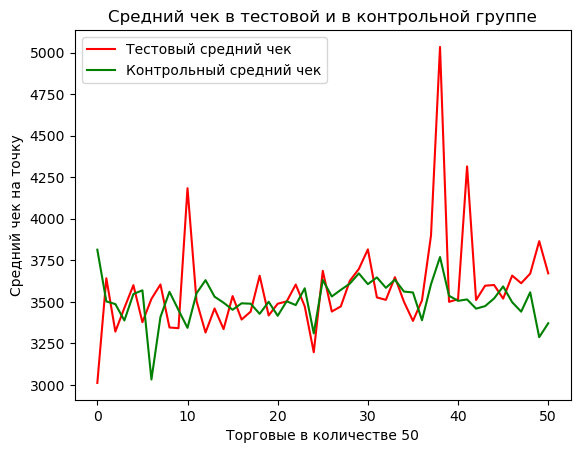

In [92]:
import matplotlib.pyplot as plt 
import numpy as np 
import math 
  
# Using Numpy to create an array X 
X = x.index 
  
# Assign variables to the y axis part of the curve 
y = avg_payment_test['avg_payment_test'] 
z = avg_payment_control['avg_payment_control'] 
  
# Plotting both the curves simultaneously 
plt.plot(X, y, color='r', label='Тестовый средний чек') 
plt.plot(X, z, color='g', label='Контрольный средний чек') 
  
# Naming the x-axis, y-axis and the whole graph 
plt.xlabel("Торговые в количестве 50") 
plt.ylabel("Средний чек на точку") 
plt.title("Средний чек в тестовой и в контрольной группе") 
  
# Adding legend, which helps us recognize the curve according to it's color 
plt.legend() 
  
# To load the display window 
plt.show() 

In [95]:
#проверяем количество точек продаж, смотрим на фрейм
table_0 = table_0.merge(avg_payment_test[['id_trading_point','avg_payment_test']], on='id_trading_point', how='outer')
table_0 = table_0.merge(avg_payment_control[['id_trading_point','avg_payment_control']], on='id_trading_point', how='outer')
print(len(table_0))
table_0.head(2)

51


,id_trading_point,city,count_all,count_test,count_control,avg_payment_test,avg_payment_control
0,2,Дмитров,24,15,9,3012.533333,3813.888889
1,11,Владимир,722,356,366,3641.952247,3502.827869


## 9. - diff - разница между средними платежами

In [96]:
table_0['diff'] = table_0['avg_payment_test'] - table_0['avg_payment_control']

In [97]:
def show(table_0): 
    print('Проверка длинны', len(table_0))

In [98]:
show(table_0)
table_0.head(3)

Проверка длинны 51


,id_trading_point,city,count_all,count_test,count_control,avg_payment_test,avg_payment_control,diff
0,2,Дмитров,24,15,9,3012.533333,3813.888889,-801.355556
1,11,Владимир,722,356,366,3641.952247,3502.827869,139.124378
2,19,Тюмень,153,80,73,3321.212500,3486.753425,-165.540925


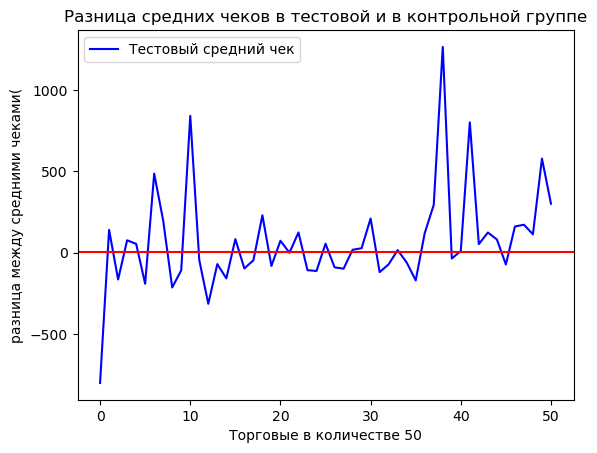

In [100]:
import matplotlib.pyplot as plt 
import numpy as np 
import math 
  
# Using Numpy to create an array X 
X = x.index 
  
# Assign variables to the y axis part of the curve 
y = table_0['diff'] 
#z = avg_payment_control['avg_payment_control'] 
  
# Plotting both the curves simultaneously 
plt.plot(X, y, color='b', label='Тестовый средний чек') 
#plt.plot(X, z, color='g', label='Контрольный средний чек') 
plt.axhline(y = 0.5, color = 'r', linestyle = '-') 
  
# Naming the x-axis, y-axis and the whole graph 
plt.xlabel("Торговые в количестве 50") 
plt.ylabel("разница между средними чеками(") 
plt.title("Разница средних чеков в тестовой и в контрольной группе") 
  
# Adding legend, which helps us recognize the curve according to it's color 
plt.legend() 
  
# To load the display window 
plt.show() 

## 10. sigma_test - стандартное отклонение платежей в тестовой группе

## 11. sigma_control - стандартное отклонение платежей в контрольной группе

In [36]:
#создаем две временные таблицы, копированием торговых точек
sigma_test = pandas.read_excel('Новый диплом датасет.xlsx', sheet_name='Region_dict')
sigma_test['sigma_test'] = pd.np.NaN

sigma_control = pandas.read_excel('Новый диплом датасет.xlsx', sheet_name='Region_dict')
sigma_control['sigma_control'] = pd.np.NaN

#Проходим циклом, проставляем значения отклонений 
#либо оставляем Nan для тех позиций где платежи были или в одной или в другой контрольной группе


for i in avg_payment_1['id_trading_point'].unique():
    test_otbor = avg_payment_1[avg_payment_1['id_trading_point'] == i]
    res_std = np.std(test_otbor['amt_payment'])
    for m in range(len(sigma_test)):
        if sigma_test['id_trading_point'][m] == i:
            sigma_test['sigma_test'][m] = res_std
        else:
            sigma_test['sigma_test'][m] = sigma_test['sigma_test'][m]
            
for i in avg_payment_0['id_trading_point'].unique():
    test_otbor = avg_payment_0[avg_payment_0['id_trading_point'] == i]
    res_std = np.std(test_otbor['amt_payment'])
    for m in range(len(sigma_control)):
        if sigma_control['id_trading_point'][m] == i:
            sigma_control['sigma_control'][m] = res_std
        else:
            sigma_control['sigma_control'][m] = sigma_control['sigma_control'][m]
            

#удаляем те самые Nan
sigma_test.dropna(inplace = True)
sigma_control.dropna(inplace = True)

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_9768\4202380964.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  sigma_test['sigma_test'] = pd.np.NaN
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_9768\4202380964.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  sigma_control['sigma_control'] = pd.np.NaN
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_9768\4202380964.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigma_test['sigma_test'][m] = sigma_test['sigma_test'][m]
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_9768\4202380964.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [37]:
#добавляем значения сигма
table_0 = table_0.merge(sigma_test[['id_trading_point','sigma_test']], on='id_trading_point', how='outer')
table_0 = table_0.merge(sigma_control[['id_trading_point','sigma_control']], on='id_trading_point', how='outer')
show(table_0)
table_0.head(2)

Проверка длинны 51


,id_trading_point,city,count_all,count_test,count_control,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control
0,2,Дмитров,24,15,9,0.625000,3012.533333,3813.888889,-801.355556,1195.072041,967.462482
1,11,Владимир,722,356,366,0.493075,3641.952247,3502.827869,139.124378,1471.081873,1502.871007


## 12. test - значение статистического критерия (критерий Стьюдента для сравнения средних платежей)
## 13. value_ttest - pvalue статистического критерия (критерий Стьюдента для сравнения средних платежей)

In [103]:
#создаем два фрейма для работы с критериями Стьюдента
Region_dict = pandas.read_excel('Новый диплом датасет.xlsx', sheet_name='Region_dict')

ttest = Region_dict
pvalue_ttest = Region_dict

ttest['ttest'] = pd.np.NaN
pvalue_ttest['pvalue_ttest'] = pd.np.NaN


C:\Users\Екатерина\AppData\Local\Temp\ipykernel_2964\1581081863.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ttest['ttest'] = pd.np.NaN
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_2964\1581081863.py:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pvalue_ttest['pvalue_ttest'] = pd.np.NaN


In [104]:
#Проходя по временным таблицам разбитого на тестовый и контрольный фрейма вносим данные 

for i in avg_payment_1['id_trading_point'].unique():
    test_otbor_0 = avg_payment_0[avg_payment_0['id_trading_point'] == i]
    test_otbor_1 = avg_payment_1[avg_payment_1['id_trading_point'] == i]
    t_stat, p_val = ttest_ind(test_otbor_0['amt_payment'], test_otbor_1['amt_payment'])
    print('по точке отбора ', i, 'посчианы t_stat, p_val', t_stat, p_val)
    for m in range(len(ttest)):
        if ttest['id_trading_point'][m] == i:
            ttest['ttest'][m] = t_stat
        else:
            ttest['ttest'][m] = ttest['ttest'][m]
    for n in range(len(pvalue_ttest)):
        if pvalue_ttest['id_trading_point'][n] == i:
            pvalue_ttest['pvalue_ttest'][n] = p_val
        else:
            pvalue_ttest['pvalue_ttest'][n] = pvalue_ttest['pvalue_ttest'][n]
            
##убираем Nan            
ttest.dropna(inplace = True)
pvalue_ttest.dropna(inplace = True)

по точке отбора  1654.0 посчианы t_stat, p_val -10.836610057633614 4.2026068707825433e-26
по точке отбора  80.0 посчианы t_stat, p_val 0.8803114206210904 0.37886148089496763
по точке отбора  309.0 посчианы t_stat, p_val 0.7765673447743359 0.4379477009513547
по точке отбора  699.0 посчианы t_stat, p_val -0.14126206256398438 0.8877055074192455
по точке отбора  212.0 посчианы t_stat, p_val 0.7739666466136602 0.43919938532381664


C:\Users\Екатерина\AppData\Local\Temp\ipykernel_2964\2740253090.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttest['ttest'][m] = ttest['ttest'][m]
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_2964\2740253090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttest['ttest'][m] = t_stat
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_2964\2740253090.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pvalue_ttest['pvalue_tt

по точке отбора  278.0 посчианы t_stat, p_val -1.1019897179017162 0.2708583296490388
по точке отбора  117.0 посчианы t_stat, p_val 0.4710363286476481 0.6377413081707883
по точке отбора  900.0 посчианы t_stat, p_val -0.830407781839288 0.4068011563583185
по точке отбора  33.0 посчианы t_stat, p_val -0.5659849320147133 0.5716674225145615
по точке отбора  6543.0 посчианы t_stat, p_val -1.5392051253853107 0.12426772285397984
по точке отбора  2652.0 посчианы t_stat, p_val -1.5280317417426659 0.1266134144048616
по точке отбора  516.0 посчианы t_stat, p_val -0.31434457162719326 0.7533216770306798
по точке отбора  277.0 посчианы t_stat, p_val 0.009885947511495219 0.9921143548088929
по точке отбора  3786.0 посчианы t_stat, p_val 0.5276900094826437 0.5980208702969776
по точке отбора  202.0 посчианы t_stat, p_val -2.395751566339794 0.016792215324909467
по точке отбора  2212.0 посчианы t_stat, p_val -1.099875982886303 0.2717990526990415
по точке отбора  991.0 посчианы t_stat, p_val -2.1327896022240

- ttest - значение статистического критерия (критерий Стьюдента для сравнения средних платежей)
- pvalue_ttest - pvalue статистического критерия (критерий Стьюдента для сравнения средних платежей)

In [105]:
table_0 = table_0.merge(ttest[['id_trading_point','ttest']], on='id_trading_point', how='outer')
table_0 = table_0.merge(pvalue_ttest[['id_trading_point','pvalue_ttest']], on='id_trading_point', how='outer')
show(table_0)
table_0.head(2)

Проверка длинны 51


,id_trading_point,city,count_all,count_test,count_control,avg_payment_test,avg_payment_control,diff,ttest,pvalue_ttest
0,2,Дмитров,24,15,9,3012.533333,3813.888889,-801.355556,1.631732,0.116969
1,11,Владимир,722,356,366,3641.952247,3502.827869,139.124378,-1.254887,0.209927


In [106]:
table_0.head(50)

,id_trading_point,city,count_all,count_test,count_control,avg_payment_test,avg_payment_control,diff,ttest,pvalue_ttest
0,2,Дмитров,24,15,9,3012.533333,3813.888889,-801.355556,1.631732,1.169692e-01
1,11,Владимир,722,356,366,3641.952247,3502.827869,139.124378,-1.254887,2.099269e-01
2,19,Тюмень,153,80,73,3321.212500,3486.753425,-165.540925,0.724941,4.696103e-01
3,33,Самара,484,308,176,3463.594156,3388.284091,75.310065,-0.565985,5.716674e-01
4,34,Самара,319,194,125,3600.587629,3547.280000,53.307629,-0.321190,7.482783e-01
5,35,Самара,257,175,82,3377.805714,3569.682927,-191.877213,0.967517,3.342025e-01
6,36,Самара,114,74,40,3518.108108,3032.975000,485.133108,-1.695344,9.278864e-02
7,54,Мурманск,616,299,317,3604.742475,3408.984227,195.758248,-1.733943,8.343014e-02
8,55,Мурманск,518,266,252,3346.026316,3560.678571,-214.652256,1.719271,8.616474e-02
9,66,Волгоград,980,450,530,3341.751111,3451.015094,-109.263983,1.169266,2.425813e-01


## 14. блице также должен присутствовать флаг (лейбл), по которому можно будет разделить торговые точки по результатам эксперимента
- Если результат (поле diff) положительный, и разница на самом деле есть (на основании p_value), то это положительный исход
- Если результат (поле diff) отрицательный, и разница на самом деле есть (на основании p_value), то это отрицательный исход
- Если разницы на самом деле нет (на основании p_value), то это нейтральный исход

In [111]:
#маркер на p_val < 0,5
test_table = table_0.copy()

#проходим по положительному и отрицательному значению dif проверяем на pvalue_ttest
#нули не берем так как ноль в тех точках, в которой или все тестовые или все контрольные закупки

test_table['flag_p_val'] = 0
for m in range(len(test_table)):
    print('-------------------------------------------------')
    print('торговая точка - ', test_table['id_trading_point'][m], 'в городе ', test_table['city'][m])
    if test_table['diff'][m] > 0:
        if test_table['pvalue_ttest'][m] > 0.05:
            test_table['flag_p_val'][m] = 1
            print('гипотеза подтверждена по торговой точке', m, 'разница diff положительна и равна', test_table['diff'][m])
            print('критерий Стьюдента', test_table['pvalue_ttest'][m])
            print('эффект от примнения push уведомлений отрицательный')
        else:
            test_table['flag_p_val'][m] = test_table['flag_p_val'][m]
    if test_table['diff'][m] < 0:
        if test_table['pvalue_ttest'][m] > 0.05:
            test_table['flag_p_val'][m] = -1
            test_table['flag_p_val'][m] = test_table['flag_p_val'][m]
            print('гипотеза  НЕ подтверждена по торговой точке', m, 'разница diff отрицательна и равна', test_table['diff'][m])
            print('критерий Стьюдента', test_table['pvalue_ttest'][m])
            print('эффект от примнения push уведомлений положительный')
        
    else:
        test_table['flag_p_val'][m] = test_table['flag_p_val'][m]
        print('в выборках разницы нетб нужны дополнительные исследования')
        
    

-------------------------------------------------
торговая точка -  2 в городе  Дмитров
гипотеза  НЕ подтверждена по торговой точке 0 разница diff отрицательна и равна -801.3555555555554
критерий Стьюдента 0.11696923540115897
эффект от примнения push уведомлений положительный
-------------------------------------------------
торговая точка -  11 в городе  Владимир
гипотеза подтверждена по торговой точке 1 разница diff положительна и равна 139.1243783385521
критерий Стьюдента 0.20992691892581744
эффект от примнения push уведомлений отрицательный
в выборках разницы нетб нужны дополнительные исследования
-------------------------------------------------
торговая точка -  19 в городе  Тюмень
гипотеза  НЕ подтверждена по торговой точке 2 разница diff отрицательна и равна -165.5409246575341
критерий Стьюдента 0.4696103452131044
эффект от примнения push уведомлений положительный
-------------------------------------------------
торговая точка -  33 в городе  Самара
гипотеза подтверждена по то

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_2964\2578160551.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_table['flag_p_val'][m] = -1
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_2964\2578160551.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_table['flag_p_val'][m] = test_table['flag_p_val'][m]
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_2964\2578160551.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [113]:
show(test_table)
test_table.head(60)

Проверка длинны 51


,id_trading_point,city,count_all,count_test,count_control,avg_payment_test,avg_payment_control,diff,ttest,pvalue_ttest,flag_p_val
0,2,Дмитров,24,15,9,3012.533333,3813.888889,-801.355556,1.631732,1.169692e-01,-1
1,11,Владимир,722,356,366,3641.952247,3502.827869,139.124378,-1.254887,2.099269e-01,1
2,19,Тюмень,153,80,73,3321.212500,3486.753425,-165.540925,0.724941,4.696103e-01,-1
3,33,Самара,484,308,176,3463.594156,3388.284091,75.310065,-0.565985,5.716674e-01,1
4,34,Самара,319,194,125,3600.587629,3547.280000,53.307629,-0.321190,7.482783e-01,1
5,35,Самара,257,175,82,3377.805714,3569.682927,-191.877213,0.967517,3.342025e-01,-1
6,36,Самара,114,74,40,3518.108108,3032.975000,485.133108,-1.695344,9.278864e-02,1
7,54,Мурманск,616,299,317,3604.742475,3408.984227,195.758248,-1.733943,8.343014e-02,1
8,55,Мурманск,518,266,252,3346.026316,3560.678571,-214.652256,1.719271,8.616474e-02,-1
9,66,Волгоград,980,450,530,3341.751111,3451.015094,-109.263983,1.169266,2.425813e-01,-1


In [114]:
#для сохранения подробим на три таблицы
tabl_0 = test_table[test_table['flag_p_val']== 0]
tabl_1 = test_table[test_table['flag_p_val']== 1]
tabl_no_1 = test_table[test_table['flag_p_val']== -1]

In [49]:
##############################################################################
##Сохраняем в EXCEL

import pandas as pd
import pandas as pd
import numpy as np
import pandas as pd


writer = pd.ExcelWriter('Дипломная работа(часть 2).xlsx')

# Write dataframe to new sheet
tabl_0.to_excel(writer, sheet_name='0')
tabl_1.to_excel(writer, sheet_name='1')
tabl_no_1.to_excel(writer, sheet_name='-1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_9768\1586110543.py:18: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


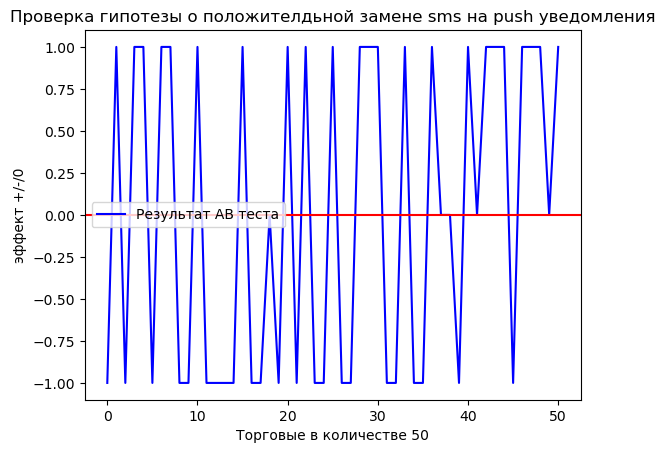

In [118]:
#для сохранения подробим на три таблицы
tabl_0 = test_table[test_table['flag_p_val']== 0]
tabl_1 = test_table[test_table['flag_p_val']== 1]
tabl_no_1 = test_table[test_table['flag_p_val']== -1]

# Using Numpy to create an array X 

  
# Assign variables to the y axis part of the curve 
y =  test_table['flag_p_val'] 
# Plotting both the curves simultaneously 
plt.plot(X, y, color='b', label='Результат AB теста') 
#plt.plot([2], n, color='g', label='Контрольный средний чек') 
plt.axhline(y = 0, color = 'r', linestyle = '-') 
  
# Naming the x-axis, y-axis and the whole graph 
plt.xlabel("Торговые в количестве 50") 
plt.ylabel("эффект +/-/0") 
plt.title("Проверка гипотезы о положителдьной замене sms на push уведомления") 
  
# Adding legend, which helps us recognize the curve according to it's color 
plt.legend() 
  
# To load the display window 
plt.show() 